In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

#plt.style.use('dark_background')
#plt.style.use('ggplot')

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [319]:
ecommerce = pd.read_csv('data/data.csv',  encoding='unicode_escape')
ecommerce.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [320]:
ecommerce = ecommerce.loc[ecommerce.Quantity>0].copy()  # DELETE CANCELLED QUANTITIES

### Check for target column distribution

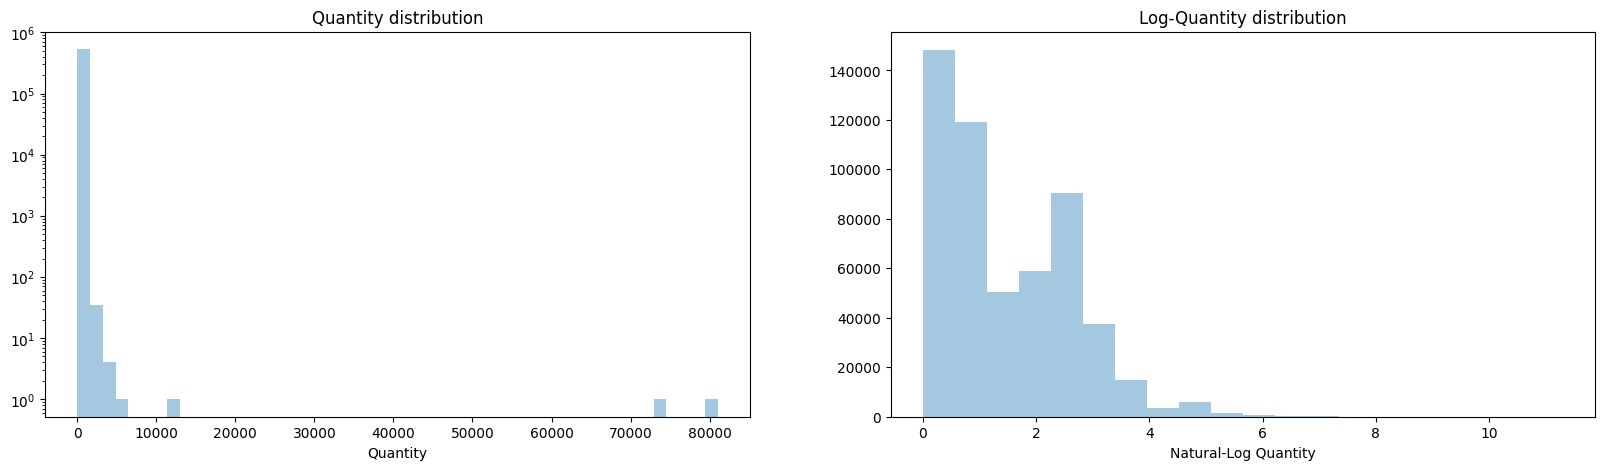

In [321]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(ecommerce.Quantity, ax=ax[0], kde=False);
sns.distplot(np.log(ecommerce.Quantity), ax=ax[1], bins=20, kde=False);
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");


#### Outliers

In [322]:
np.exp(4)  # Cut at

54.598150033144236

In [323]:
np.quantile(ecommerce.Quantity, 0.95)

30.0

In [324]:
ecommerce = ecommerce.loc[ecommerce.Quantity < 55].copy()

In [325]:
ecommerce.shape

(519064, 8)

In [326]:
ecommerce = ecommerce[['InvoiceDate','Quantity']]

In [327]:
ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519064 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceDate  519064 non-null  object
 1   Quantity     519064 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.9+ MB


In [328]:
missing_values = ecommerce.isnull().sum()
missing_values

InvoiceDate    0
Quantity       0
dtype: int64

In [329]:
ecommerce['InvoiceDate'] = pd.to_datetime(ecommerce['InvoiceDate'])
ecommerce

,InvoiceDate,Quantity
0,2010-12-01 08:26:00,6
1,2010-12-01 08:26:00,6
2,2010-12-01 08:26:00,8
3,2010-12-01 08:26:00,6
4,2010-12-01 08:26:00,6
...,...,...
541904,2011-12-09 12:50:00,12
541905,2011-12-09 12:50:00,6
541906,2011-12-09 12:50:00,4
541907,2011-12-09 12:50:00,4


In [330]:
date_range = ecommerce['InvoiceDate'].max() - ecommerce['InvoiceDate'].min()
date_range

Timedelta('373 days 04:24:00')

In [331]:
ecommerce = ecommerce.set_index('InvoiceDate')

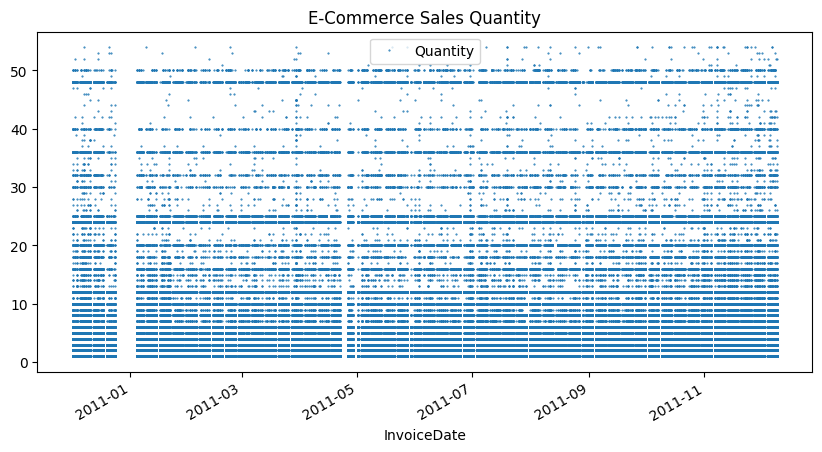

In [332]:
color_pal = sns.color_palette()

ecommerce.plot(style='.', figsize=(10,5), ms=1, color=color_pal[0], title="E-Commerce Sales Quantity")
plt.show()

<Axes: >

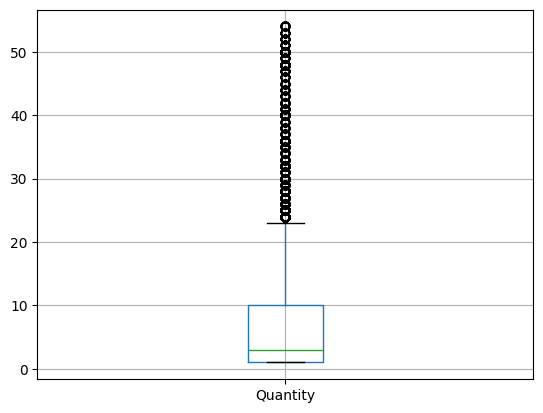

In [333]:
ecommerce.boxplot()

# Resample data to 1 hour intervals

In [334]:
ecommerce = ecommerce.resample('1H').sum()  # Resample to 1-hour intervals and sum quantities

In [335]:
ecommerce

,Quantity
InvoiceDate,
2010-12-01 08:00:00,602
2010-12-01 09:00:00,1261
2010-12-01 10:00:00,1414
2010-12-01 11:00:00,2004
2010-12-01 12:00:00,2215
...,...
2011-12-09 08:00:00,2033
2011-12-09 09:00:00,836
2011-12-09 10:00:00,4770


<Axes: >

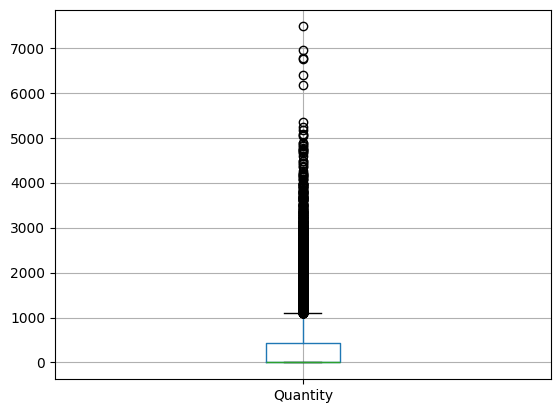

In [336]:
ecommerce.boxplot()

In [337]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(ecommerce, label='Quantity')
features_and_target = pd.concat([X, y], axis=1)

In [346]:
saturday_data = features_and_target[features_and_target['weekday'] == 'Saturday']

saturday_y = saturday_data['Quantity']
saturday_y.max() # WE DO NOT HAVE DATA FOR SATURDAYS

0

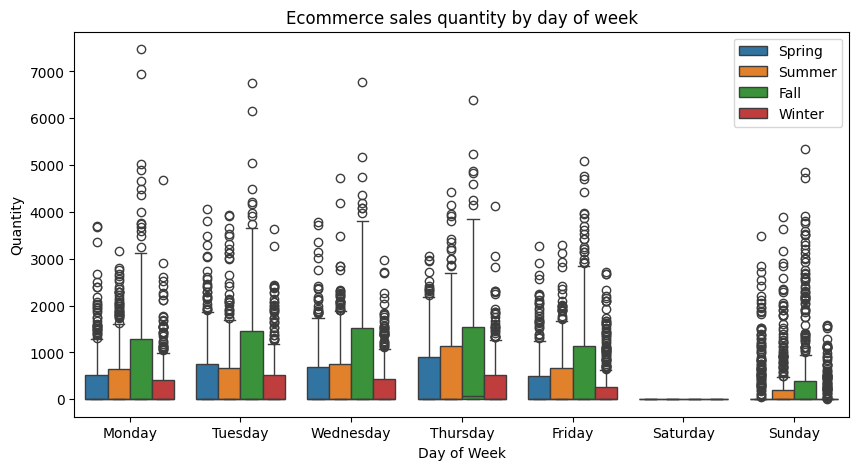

In [347]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Quantity',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Ecommerce sales quantity by day of week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Quantity')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## FALL INCREMENT IN SALES MIGHT SUGGEST CHRISTMAS SEASON INFLUENCES THE QUANTITY

# Train / Test Split

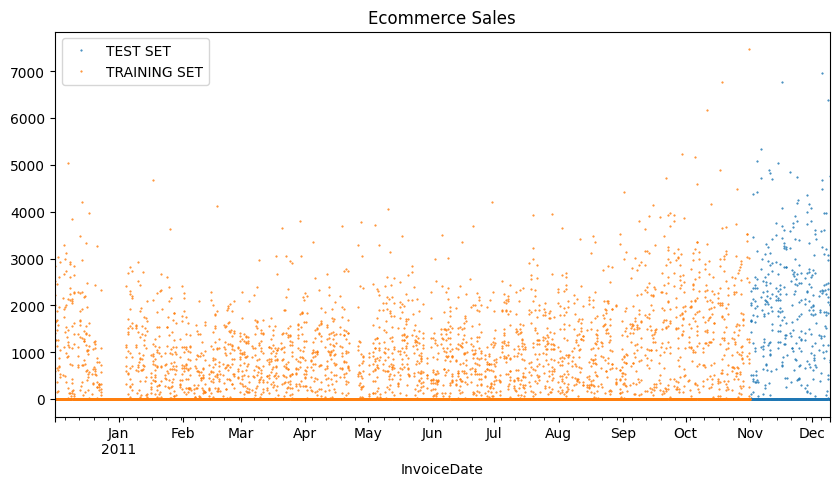

In [349]:
split_date = '1-Nov-11'
ecommerce_train = ecommerce.loc[ecommerce.index <= split_date].copy()
ecommerce_test = ecommerce.loc[ecommerce.index > split_date].copy()

ecommerce_test \
    .rename(columns={'Quantity': 'TEST SET'}) \
    .join(ecommerce_train.rename(columns={'Quantity': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Ecommerce Sales', style='.', ms=1)
plt.show()

# Prophet Model

In [354]:
ecommerce_train_prophet = ecommerce_train.reset_index() \
    .rename(columns={'InvoiceDate':'ds',
                     'Quantity':'y'})


In [355]:
ecommerce_train_prophet

,ds,y
0,2010-12-01 08:00:00,602
1,2010-12-01 09:00:00,1261
2,2010-12-01 10:00:00,1414
3,2010-12-01 11:00:00,2004
4,2010-12-01 12:00:00,2215
...,...,...
8028,2011-10-31 20:00:00,0
8029,2011-10-31 21:00:00,0
8030,2011-10-31 22:00:00,0
8031,2011-10-31 23:00:00,0


In [356]:
%%time
model = Prophet()
model.fit(ecommerce_train_prophet)

22:10:05 - cmdstanpy - INFO - Chain [1] start processing
22:10:11 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 609 ms
Wall time: 6.31 s


In [357]:
ecommerce_test_prophet = ecommerce_test.reset_index() \
    .rename(columns={'InvoiceDate':'ds',
                     'Quantity':'y'})

In [360]:
ecommerce_test_forecast = model.predict(ecommerce_test_prophet)

In [362]:
ecommerce_test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-11-01 01:00:00,629.176058,-364.738105,946.325355,629.176058,629.176058,-299.292004,-299.292004,-299.292004,-377.576920,-377.576920,-377.576920,78.284915,78.284915,78.284915,0.0,0.0,0.0,329.884054
1,2011-11-01 02:00:00,629.318104,-297.695500,1033.215344,629.318104,629.318104,-257.802306,-257.802306,-257.802306,-339.722230,-339.722230,-339.722230,81.919924,81.919924,81.919924,0.0,0.0,0.0,371.515798
2,2011-11-01 03:00:00,629.460149,-271.635157,987.229831,629.460149,629.460149,-235.362197,-235.362197,-235.362197,-321.067159,-321.067159,-321.067159,85.704962,85.704962,85.704962,0.0,0.0,0.0,394.097952
3,2011-11-01 04:00:00,629.602194,-314.861875,980.099772,629.602194,629.602194,-261.606129,-261.606129,-261.606129,-351.206885,-351.206885,-351.206885,89.600756,89.600756,89.600756,0.0,0.0,0.0,367.996065
4,2011-11-01 05:00:00,629.744239,-319.740920,956.392093,629.744239,629.744239,-309.789227,-309.789227,-309.789227,-403.353125,-403.353125,-403.353125,93.563898,93.563898,93.563898,0.0,0.0,0.0,319.955012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2011-12-09 08:00:00,759.715644,252.310302,1443.273658,727.334213,792.534310,82.876432,82.876432,82.876432,-42.587565,-42.587565,-42.587565,125.463997,125.463997,125.463997,0.0,0.0,0.0,842.592076
920,2011-12-09 09:00:00,759.857690,434.873310,1781.537049,727.409288,792.673814,378.307138,378.307138,378.307138,269.266021,269.266021,269.266021,109.041117,109.041117,109.041117,0.0,0.0,0.0,1138.164828
921,2011-12-09 10:00:00,759.999735,757.260238,2116.504194,727.484363,792.813318,656.650524,656.650524,656.650524,565.271107,565.271107,565.271107,91.379417,91.379417,91.379417,0.0,0.0,0.0,1416.650259
922,2011-12-09 11:00:00,760.141780,935.981487,2257.609579,727.559438,792.952822,854.573144,854.573144,854.573144,782.001937,782.001937,782.001937,72.571208,72.571208,72.571208,0.0,0.0,0.0,1614.714924


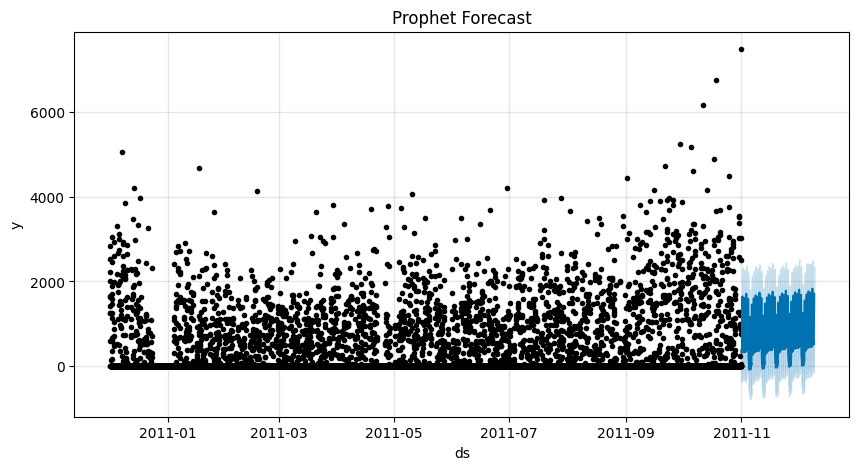

In [363]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(ecommerce_test_forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

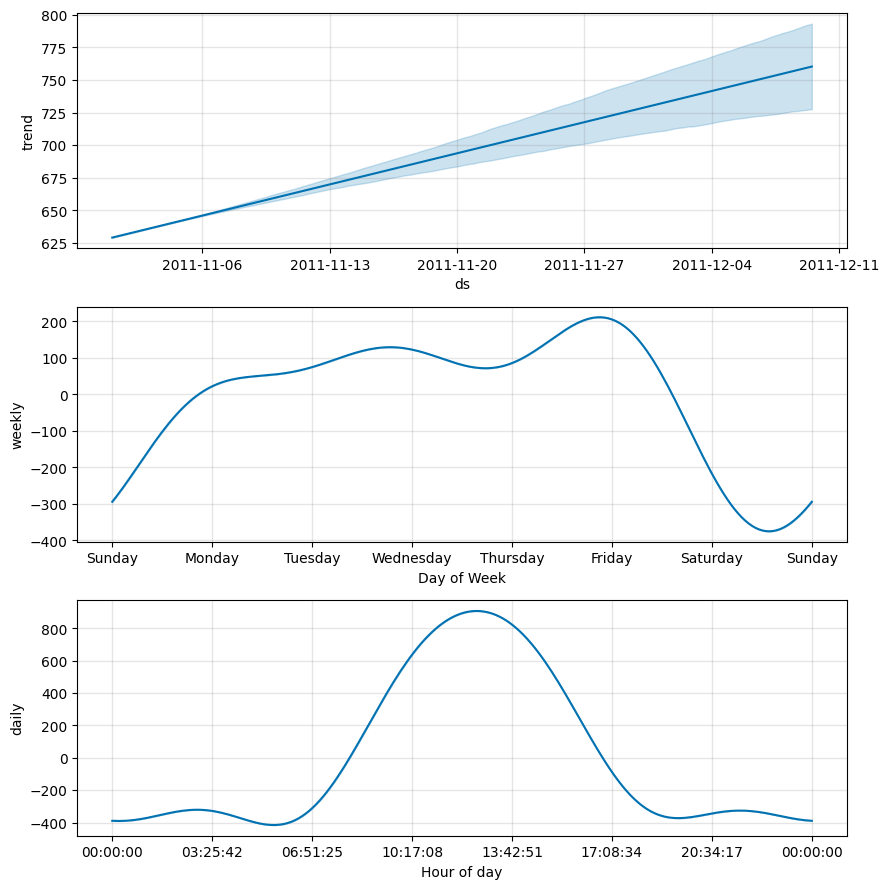

In [364]:
fig = model.plot_components(ecommerce_test_forecast)
plt.show()

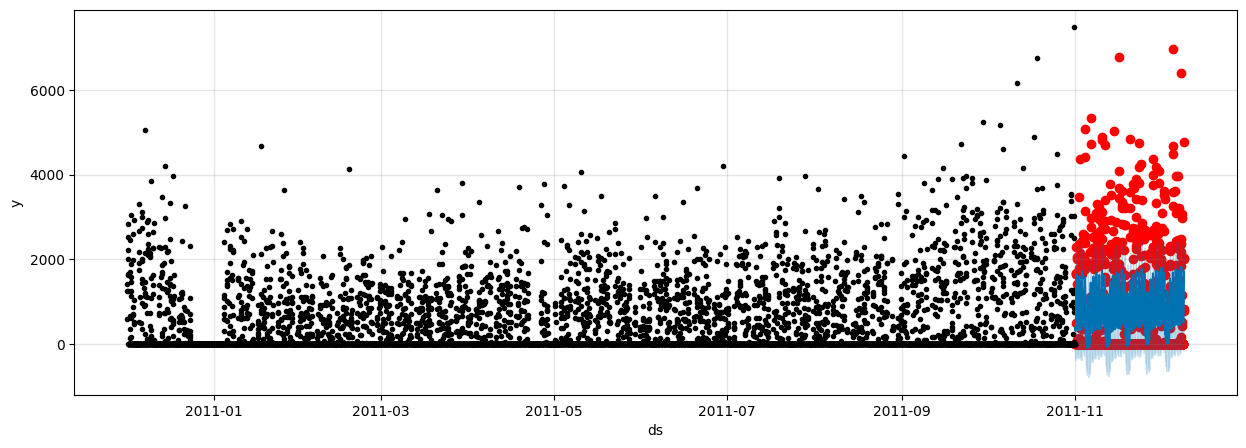

In [365]:


# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(ecommerce_test.index, ecommerce_test['Quantity'], color='r')
fig = model.plot(ecommerce_test_forecast, ax=ax)

